In [7]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
from scipy.special import entr
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.stats import skew, kurtosis
from scipy.signal import welch

In [2]:
dataset_path_1st = './1st_test/1st_test'
dataset_path_2nd = './2nd_test/2nd_test'
dataset_path_3rd = './3rd_test/4th_test/txt'

In [3]:
dataset = pd.read_csv('./2nd_test/2nd_test/2004.02.12.10.32.39', sep='\t')
dataset.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
dataset.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,-0.042,-0.073,-0.007,-0.105
1,0.015,0.000,0.007,0.000
2,-0.051,0.020,-0.002,0.100
3,-0.107,0.010,0.127,0.054
4,-0.078,-0.212,0.042,-0.044


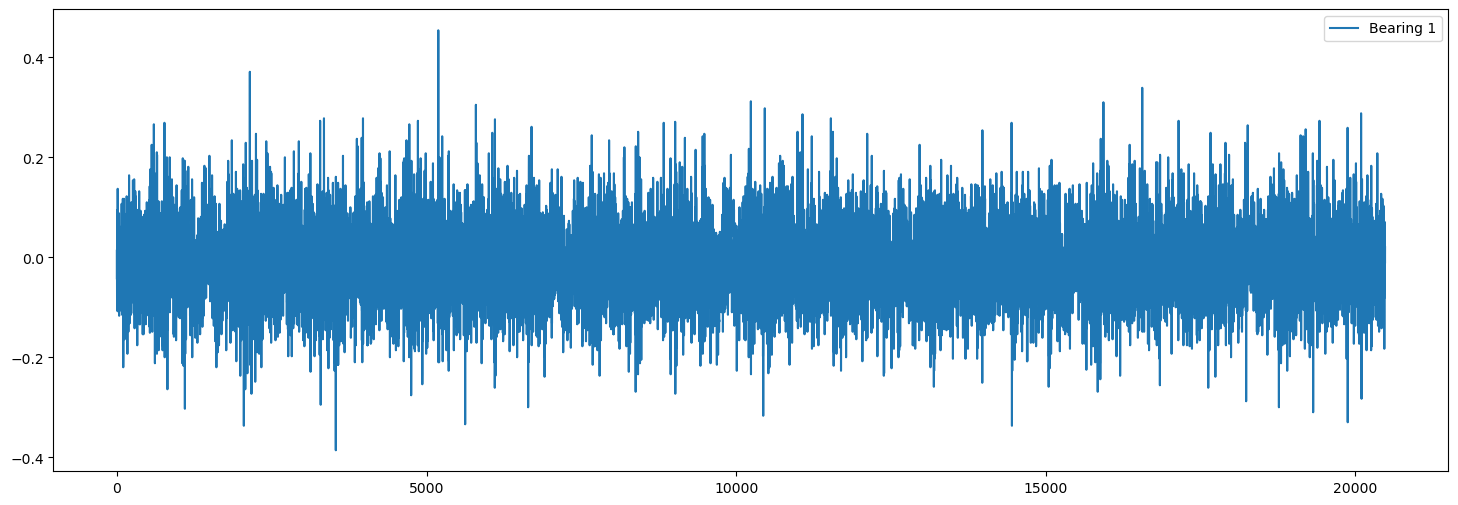

In [5]:
# raw signal
dataset[['Bearing 1']].plot(figsize=(18,6));

In [11]:
def load_bearing_data(file_path, test_number=1):
    """
    Load one data file from the IMS dataset.
    For test 1: expects 8 channels. For test 2 & 3: expects 4 channels.
    """
    # The IMS files are whitespace-separated, no header, no extension.
    df = pd.read_csv(file_path, header=None, delimiter=r"\s+")
    
    if test_number == 1:
        # 8 channels -> 2 channels per bearing
        df.columns = [
            "B1_ch1", "B1_ch2",
            "B2_ch1", "B2_ch2",
            "B3_ch1", "B3_ch2",
            "B4_ch1", "B4_ch2"
        ]
    else:
        # 4 channels -> 1 channel per bearing
        df.columns = ["B1", "B2", "B3", "B4"]
    
    return df

def combine_channels_if_needed(df, test_number=1):
    """
    For test 1, average the two channels per bearing into a single column.
    For test 2 & 3, return the DataFrame as-is.
    """
    if test_number == 1:
        data_dict = {
            'B1': df[['B1_ch1', 'B1_ch2']].mean(axis=1),
            'B2': df[['B2_ch1', 'B2_ch2']].mean(axis=1),
            'B3': df[['B3_ch1', 'B3_ch2']].mean(axis=1),
            'B4': df[['B4_ch1', 'B4_ch2']].mean(axis=1)
        }
        return pd.DataFrame(data_dict)
    else:
        return df

In [12]:
def extract_time_features(signal):
    feats = {}
    feats['rms'] = np.sqrt(np.mean(signal**2))
    feats['std'] = np.std(signal)
    feats['skew'] = skew(signal)
    feats['kurtosis'] = kurtosis(signal)
    feats['peak'] = np.max(np.abs(signal))
    feats['ptp'] = np.max(signal) - np.min(signal)  # peak-to-peak
    feats['crest'] = feats['peak'] / feats['rms'] if feats['rms'] != 0 else 0
    return feats

In [13]:
def extract_frequency_features(signal, fs=20000):
    """
    Compute spectral centroid, bandwidth, and dominant frequency using Welch's PSD.
    """
    freqs, psd = welch(signal, fs=fs, nperseg=1024)
    psd_sum = np.sum(psd)
    if psd_sum == 0:
        # Edge case: if PSD sums to zero (all zeros?), just return zeros
        return {
            'spectral_centroid': 0,
            'spectral_bandwidth': 0,
            'dominant_freq': 0
        }
    
    psd_norm = psd / psd_sum
    centroid = np.sum(freqs * psd_norm)
    bandwidth = np.sqrt(np.sum(((freqs - centroid)**2) * psd_norm))
    dominant_freq = freqs[np.argmax(psd)]
    
    return {
        'spectral_centroid': centroid,
        'spectral_bandwidth': bandwidth,
        'dominant_freq': dominant_freq
    }

In [14]:
def extract_all_features(signal, fs=20000):
    feats_time = extract_time_features(signal)
    feats_freq = extract_frequency_features(signal, fs=fs)
    # Merge the two dictionaries
    return {**feats_time, **feats_freq}

In [15]:
def process_single_file(file_path, test_number=1, fs=20000, combine_channels=True):
    """
    Load one file, optionally combine channels (for test 1),
    then extract features for each bearing.
    """
    df = load_bearing_data(file_path, test_number=test_number)
    if test_number == 1 and combine_channels:
        df = combine_channels_if_needed(df, test_number=test_number)
    
    feature_list = []
    for bearing_col in df.columns:
        signal = df[bearing_col].values
        feats = extract_all_features(signal, fs=fs)
        feats['file'] = os.path.basename(file_path)
        feats['bearing'] = bearing_col
        feature_list.append(feats)
    return feature_list

def process_directory(directory_path, test_number=1, fs=20000, combine_channels=True):
    """
    Loops over all files in the specified directory,
    extracts features, and returns a DataFrame.
    """
    all_features = []
    file_list = sorted(os.listdir(directory_path))
    
    for file_name in file_list:
        # IMS bearing files often start with 2003. or 2004.
        if file_name.startswith('2003.') or file_name.startswith('2004.'):
            file_path = os.path.join(directory_path, file_name)
            feature_rows = process_single_file(
                file_path, 
                test_number=test_number, 
                fs=fs, 
                combine_channels=combine_channels
            )
            all_features.extend(feature_rows)
    
    return pd.DataFrame(all_features)

In [16]:
# Define your dataset paths
dataset_path_1st = './1st_test/1st_test'
dataset_path_2nd = './2nd_test/2nd_test'
dataset_path_3rd = './3rd_test/4th_test/txt'

# Process each test set
features_1st = process_directory(dataset_path_1st, test_number=1, fs=20000, combine_channels=True)
features_2nd = process_directory(dataset_path_2nd, test_number=2, fs=20000, combine_channels=False)
features_3rd = process_directory(dataset_path_3rd, test_number=3, fs=20000, combine_channels=False)

# Tag them with test_set info
features_1st['test_set'] = '1st'
features_2nd['test_set'] = '2nd'
features_3rd['test_set'] = '3rd'

# Combine into one DataFrame if desired
features_all = pd.concat([features_1st, features_2nd, features_3rd], ignore_index=True)

print("1st test shape:", features_1st.shape)
print("2nd test shape:", features_2nd.shape)
print("3rd test shape:", features_3rd.shape)
print("Combined shape:", features_all.shape)

# Quick peek at the combined data
features_all.head()

1st test shape: (8624, 13)
2nd test shape: (3936, 13)
3rd test shape: (25296, 13)
Combined shape: (37856, 13)


,rms,std,skew,kurtosis,peak,ptp,crest,spectral_centroid,spectral_bandwidth,dominant_freq,file,bearing,test_set
0,0.103974,0.043934,0.225763,3.789936,0.3955,0.7680,3.803821,4208.630919,2935.224008,996.09375,2003.10.22.12.06.24,B1,1st
1,0.115741,0.067827,-0.052562,-0.062400,0.5090,0.6835,4.397752,2791.647233,2929.000995,996.09375,2003.10.22.12.06.24,B2,1st
2,0.112216,0.065874,0.027662,0.514030,0.4960,0.7290,4.420040,4847.749481,3287.815578,976.56250,2003.10.22.12.06.24,B3,1st
3,0.101038,0.040418,0.115538,1.575137,0.3345,0.5925,3.310631,4681.519962,3167.264920,488.28125,2003.10.22.12.06.24,B4,1st
4,0.103631,0.042763,0.149834,2.868064,0.3855,0.6420,3.719920,4160.162522,2949.149598,996.09375,2003.10.22.12.09.13,B1,1st


In [20]:
# Prosesser og lagre 1st_test
features_1st = process_directory(dataset_path_1st, test_number=1, fs=20000, combine_channels=True)
features_1st['test_set'] = '1st'
features_1st.to_csv('1st_test_withfeatures.csv', index=False)

features_2nd = process_directory(dataset_path_2nd, test_number=2, fs=20000, combine_channels=False)
features_2nd['test_set'] = '2nd'
features_2nd.to_csv('2nd_test_withfeatures.csv', index=False)

In [22]:
pd.read_csv('./2nd_test_withfeatures.csv')

,rms,std,skew,kurtosis,peak,ptp,crest,spectral_centroid,spectral_bandwidth,dominant_freq,file,bearing,test_set
0,0.074179,0.073475,0.083993,0.628763,0.454,0.840,6.120331,3071.626665,2109.189278,976.56250,2004.02.12.10.32.39,B1,2nd
1,0.090944,0.090053,0.126915,0.506801,0.513,0.977,5.640841,3414.939243,2633.186077,976.56250,2004.02.12.10.32.39,B2,2nd
2,0.109404,0.108434,0.204840,3.213075,1.023,1.934,9.350652,4391.368144,2437.383528,976.56250,2004.02.12.10.32.39,B3,2nd
3,0.054103,0.053166,-0.022080,0.065959,0.264,0.457,4.879539,2852.347027,2107.934790,976.56250,2004.02.12.10.32.39,B4,2nd
4,0.075382,0.075338,0.052142,0.648291,0.388,0.757,5.147086,3148.393914,2145.922409,976.56250,2004.02.12.10.42.39,B1,2nd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,0.002154,0.001204,0.656680,1.652722,0.005,0.007,2.321622,2770.191848,3113.540504,58.59375,2004.02.19.06.12.39,B4,2nd
3932,0.001533,0.001000,0.317032,-1.609774,0.005,0.007,3.262149,1944.458228,2986.689136,58.59375,2004.02.19.06.22.39,B1,2nd
3933,0.001239,0.001021,-0.250340,-1.094099,0.002,0.004,1.614597,2013.514933,2975.750279,58.59375,2004.02.19.06.22.39,B2,2nd
3934,0.001197,0.000996,-0.395449,-1.069012,0.005,0.007,4.176749,1879.187647,2827.986868,58.59375,2004.02.19.06.22.39,B3,2nd
